In [83]:
import gym
import copy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from MCTS import MCTS
from model import PolicyNet

In [84]:
GRID = 7

In [85]:
def to_numpy(state): 
    # Takes a state as given by env.step and return the numpy array for the board and the passing indicator
    P0 = state[0] # 2D array of the pieces of P0
    P1 = state[1] # 2D array of the pieces of P1
    turn = state[2][0][0] # =0 if it's P0's turn =1 if P1's
    prev_pass =  state[4][0][0] # Indicicator for whether the previous turn was a pass
    if turn == 0: # Board representation, 1 for the current player's pieces -1 for the other's
        board = P0 - P1
    else :
        board = P1 - P0
    return board, prev_pass

In [86]:
lr=5e-3
nb_data_gather_games=10
max_time_step = 20
temperature = 5
c = 1
batch_size = 32
epochs = 200
tournament_len = 3
time_limit = 150 #ms

In [87]:
env_state = gym.make('gym_go:go-v0', size=GRID, reward_method='real')

In [88]:
load_model_path=''
save_model_path='mod_1.h5'

In [89]:
if load_model_path == '':
    MctsD = MCTS(PolicyNet(GRID, 5, GRID**2+1, reg=0.001), time_limit, GRID)
    MctsT = MCTS(PolicyNet(GRID, 5, GRID**2+1, reg=0.001), time_limit, GRID)
else :
    mod = tf.keras.models.load_model(load_model_path)
    MctsD = MCTS(mod, time_limit, GRID)
    MctsT = MCTS(mod, time_limit, GRID)

In [90]:
optimizer = tf.optimizers.Adam(lr)

In [91]:
All_losses = []
for loop in range(10):
    HIST = []
    for game_ix in range(nb_data_gather_games):
        print(f"self-play game {game_ix+1}")
        state = env_state.reset()
        t=0
        while t<max_time_step : #and avg_v > min_val:
            t0 = time.time()
            pie, actions = MctsD.search(env_state, temperature, c)
            #print(f"MCTS search took {time.time()-t0} seconds")
            HIST.append((to_numpy(state), pie, actions, env_state.turn()))
            action = np.random.choice(actions, p=pie)
            state, _, _, _ = env_state.step(action)
            if env_state.game_ended():
                break
            t += 1
        z = 0 if env_state.get_winning()==1 else 1

    print(f"Starting training")

    boardDat = tf.data.Dataset.from_generator(lambda: iter([board.flatten() for (board, _), _, _, _ in HIST]), tf.float32)
    indDat = tf.data.Dataset.from_generator(lambda: iter([[ind] for (_, ind), _, _, _ in HIST]), tf.float32)
    
    PL = []
    for _, pie, actions, _ in HIST:
        pl = np.zeros(GRID*GRID+1)
        
        for idd, ix in enumerate(actions.flatten()):
            if ix is None:
                pl[-1] = pie[idd]
            else :
                pl[ix] = pie[idd]
        PL.append(list(pl))
    pieDat = tf.data.Dataset.from_generator(lambda: iter(PL), tf.float32)
    zDat = tf.data.Dataset.from_generator(lambda: iter([[int(z==turn_id)] for _, _, _, turn_id in HIST]), tf.float32) 
    
    dataset = tf.data.Dataset.zip((boardDat, indDat, pieDat, zDat))
    print(dataset)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    iterator = list(dataset.as_numpy_iterator())
    
    for epoch in range(epochs):
        #print(f"Training epoch {epoch+1}")
        losses = []
        for batch in iterator:
            # Inputs: board as a numpy array and passing indicator (ind)
            # Labels: Target probability distribution (pie) and winning indicator (z)
            board, ind, pie, z = batch 
            
            board = tf.reshape(board, (batch_size, GRID, GRID, 1))
            ind = tf.reshape(ind, (batch_size, 1))

            with tf.GradientTape() as tape:
                
                p, v = MctsT.guidingNet(board, ind, training=True)
                
                MSE = tf.losses.MSE(z,v)
                CE = tf.losses.categorical_crossentropy(pie, p)
                RL = 0 # Regularization loss
                for lo in MctsT.guidingNet.losses: # Adding the regularization terms for each layer
                    RL+=lo
                loss = MSE+10*CE+RL
                losses.append((MSE.numpy(), CE.numpy(), [RL.numpy() for _ in CE.numpy()]))
                variables = MctsT.guidingNet.trainable_variables # Get the trainable variables
                gradients = tape.gradient(loss, variables) # Compute the gradients of the loss wrt those variables

            optimizer.apply_gradients(zip(gradients, variables)) # Update the trainable weights
        print(f"Mean MSE, CE and RL losses on epoch {epoch+1} are {np.mean(np.mean(losses, axis=2), axis=0)}")
        
        All_losses.append(np.mean(np.mean(losses, axis=2), axis=0))
    
    print(f"Starting tournament")
    t_score = 0
    for i in range(tournament_len):
        print(f"Tournament game {i}")
        # Tournamnet to see would wins in a MCTS battle between the training net and the data generation net
        env_state.reset()
        A = ['t', 'd'] if i%2 else ['d', 't'] # To alternate who starts
        D = {'t' : MctsT,  'd' : MctsD}
        t=0
        while t<max_time_step : # and avg_v > min_val:
            for k in A:
                pie, actions = D[k].search(env_state, temperature, c)
                action = np.random.choice(actions, p=pie)
                env_state.step(action)
                if env_state.game_ended():
                    break
                t+=1
            if env_state.game_ended():
                    break

        z = env_state.get_winning()

        if z == 1:
            # A[0] won cuz he started
            if A[0] == 't':
                t_score += 1
            else :
                t_score -= 1
        elif z == -1:
            # A[1] won cuz he didnt start
            if A[1] == 't':
                t_score += 1
            else :
                t_score -= 1
    print(f"tournament ended with a score for the Training net of {t_score}")
    # Here t_score represent the game_won-game_lost for the training network 
    if t_score>0 : 
        # If the training net won more games that means it's better so we use it for the next MCTS data gathering
        MctsD.guidingNet = copy.copy(MctsT.guidingNet)

, CE and RL losses on epoch 176 are [0.00543339 3.8468344  0.07662909]
Mean MSE, CE and RL losses on epoch 177 are [0.00488051 3.846988   0.07725544]
Mean MSE, CE and RL losses on epoch 178 are [8.8809285e-04 3.8467195e+00 7.7909790e-02]
Mean MSE, CE and RL losses on epoch 179 are [5.593284e-04 3.845876e+00 7.845741e-02]
Mean MSE, CE and RL losses on epoch 180 are [1.6847362e-04 3.8451166e+00 7.9023398e-02]
Mean MSE, CE and RL losses on epoch 181 are [2.7508079e-04 3.8446112e+00 7.9682164e-02]
Mean MSE, CE and RL losses on epoch 182 are [1.8681529e-04 3.8440278e+00 8.0405280e-02]
Mean MSE, CE and RL losses on epoch 183 are [1.4579167e-04 3.8438704e+00 8.1082366e-02]
Mean MSE, CE and RL losses on epoch 184 are [3.4597158e-04 3.8439934e+00 8.1793003e-02]
Mean MSE, CE and RL losses on epoch 185 are [2.0973939e-04 3.8435867e+00 8.2489312e-02]
Mean MSE, CE and RL losses on epoch 186 are [4.6280108e-04 3.8433640e+00 8.3169743e-02]
Mean MSE, CE and RL losses on epoch 187 are [2.2042426e-04 3.

In [92]:
MctsT.guidingNet.save_weights(save_model_path)

(2000, 3)


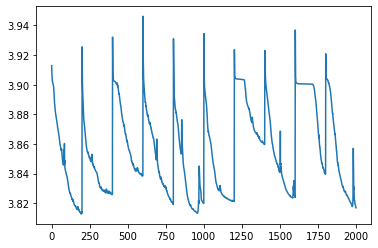

In [93]:
print(np.shape(All_losses))
plt.plot(np.array(All_losses)[:, 1])


In [103]:
adversary = MCTS(PolicyNet(GRID, 5, GRID**2+1, reg=0.001), time_limit, GRID)

env_state = gym.make('gym_go:go-v0', size=GRID, reward_method='real')
adversary.guidingNet(tf.zeros((1, GRID, GRID, 1)), tf.zeros((1, 1)))
adversary.guidingNet.load_weights(save_model_path)
env_state.render()
while not(env_state.game_ended()):
    ax = int(input("x"))
    ay = int(input("y"))

    env_state.step((ax, ay))

    pie, actions = adversary.search(env_state, temperature, c)
    print(adversary.root.V)
    action = np.random.choice(actions, p=pie)
    env_state.step(action)
    env_state.render()

0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------
	Turn: B, Last Turn Passed: False, Game Over: 0
	Black Area: 0.0, White Area: 0.0


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you c

AssertionError: 